In [2]:
# Please run this cell first!

library(tidyverse)
library(tidymodels)
library(kknn)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
#Please run this cell second!
options(repr.plot.width = 8, repr.plot.height = 6)

# Data Loading and Wrangling 

In [5]:
players <- read_csv('players.csv')

# chose to select experience, played_hours, and subscribers 
#   since they are the relevant factors to creating this model
players_relevant_subset <- players |>
  select(experience, played_hours, subscribe) |>
  mutate(subscribe = as.factor(subscribe), experience = as.factor(experience))

head(players_relevant_subset)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,subscribe
<fct>,<dbl>,<fct>
Pro,30.3,TRUE
Veteran,3.8,TRUE
Veteran,0.0,FALSE
Amateur,0.7,TRUE
Regular,0.1,TRUE
Amateur,0.0,TRUE


## Data Quality Check

In [12]:
players_subset_clean <- players_relevant_subset |>
    filter(!is.na(experience), !is.na(played_hours), !is.na(subscribe))

# players_subset_clean

# Exploratory Data Analysis

## Univariate Analysis

In [30]:
# experience counts and proportions
experience_summary <- players_subset_clean |>
    summarize(
        experience_levels = n_distinct(experience))

experience_counts <- players_subset_clean |>
    count(experience, sort = TRUE) |>
    mutate(prop = n / sum(n) * 100)
        

experience_summary
experience_counts

experience_levels
<int>
5


experience,n,prop
<fct>,<int>,<dbl>
Amateur,63,32.142857
Veteran,48,24.489796
Regular,36,18.367347
Beginner,35,17.857143
Pro,14,7.142857


In [31]:
# Subscribe counts and proportions
subscribe_counts <- players_subset_clean |>
    count(subscribe, sort = TRUE) |>
    mutate(prop = n / sum(n) * 100)
        
subscribe_counts

subscribe,n,prop
<fct>,<int>,<dbl>
TRUE,144,73.46939
FALSE,52,26.53061


In [25]:
# played_hours distribution statistics
played_hours_summary <- players_subset_clean |>
    summarise(
        missing = sum(is.na(played_hours)),
        min  = min(played_hours, na.rm = TRUE),
        q1   = quantile(played_hours, 0.25, na.rm = TRUE),
        med  = median(played_hours, na.rm = TRUE),
        mean = mean(played_hours, na.rm = TRUE),
        q3   = quantile(played_hours, 0.75, na.rm = TRUE),
        max  = max(played_hours, na.rm = TRUE),
        sd   = sd(played_hours, na.rm = TRUE)
            )

played_hours_summary

missing,min,q1,med,mean,q3,max,sd
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,0,0.1,5.845918,0.6,223.1,28.35734


## Bivariate Analysis and Relationships 

### subscribe by experience

In [34]:
subscribe_by_experience <- players_subset_clean |>
    count(experience, subscribe) |>
    group_by(experience) |>
    mutate(prop_within_experience = n / sum(n)) |>
    ungroup() |>
    arrange(experience, desc(prop_within_experience))

subscribe_by_experience

experience,subscribe,n,prop_within_experience
<fct>,<fct>,<int>,<dbl>
Amateur,TRUE,45,0.7142857
Amateur,FALSE,18,0.2857143
Beginner,TRUE,27,0.7714286
Beginner,FALSE,8,0.2285714
Pro,TRUE,10,0.7142857
Pro,FALSE,4,0.2857143
Regular,TRUE,29,0.8055556
Regular,FALSE,7,0.1944444
Veteran,TRUE,33,0.6875000


### played_hours by experience

In [40]:
played_hours_by_experience <- players_subset_clean |>
    group_by(experience) |>
    summarise(
        count = n(),
        missing = sum(is.na(played_hours)),
        min  = min(played_hours, na.rm = TRUE),
        q1   = quantile(played_hours, 0.25, na.rm = TRUE),
        med  = median(played_hours, na.rm = TRUE),
        mean = mean(played_hours, na.rm = TRUE),
        q3   = quantile(played_hours, 0.75, na.rm = TRUE),
        max  = max(played_hours, na.rm = TRUE),
        sd   = sd(played_hours, na.rm = TRUE)
            ) |>
    arrange(desc(med))

played_hours_by_experience

experience,count,missing,min,q1,med,mean,q3,max,sd
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,14,0,0,0.125,0.3,2.6000000,0.900,30.3,7.988838
Amateur,63,0,0,0.000,0.1,6.0174603,0.700,150.0,21.987214
Beginner,35,0,0,0.000,0.1,1.2485714,0.900,23.7,4.105547
Regular,36,0,0,0.000,0.1,18.2083333,0.600,223.1,57.957346
Veteran,48,0,0,0.000,0.1,0.6479167,0.225,12.5,1.937424


### played_hours by subscrive

In [41]:
played_hours_by_subscribe <- players_subset_clean |>
    group_by(subscribe) |>
    summarise(
        count = n(),
        missing = sum(is.na(played_hours)),
        min  = min(played_hours, na.rm = TRUE),
        q1   = quantile(played_hours, 0.25, na.rm = TRUE),
        med  = median(played_hours, na.rm = TRUE),
        mean = mean(played_hours, na.rm = TRUE),
        q3   = quantile(played_hours, 0.75, na.rm = TRUE),
        max  = max(played_hours, na.rm = TRUE),
        sd   = sd(played_hours, na.rm = TRUE)
            ) |>
  arrange(subscribe)

played_hours_by_subscribe

subscribe,count,missing,min,q1,med,mean,q3,max,sd
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,52,0,0,0,0.0,0.5019231,0.225,7.1,1.188258
TRUE,144,0,0,0,0.1,7.7756944,0.700,223.1,32.892470


## Plots

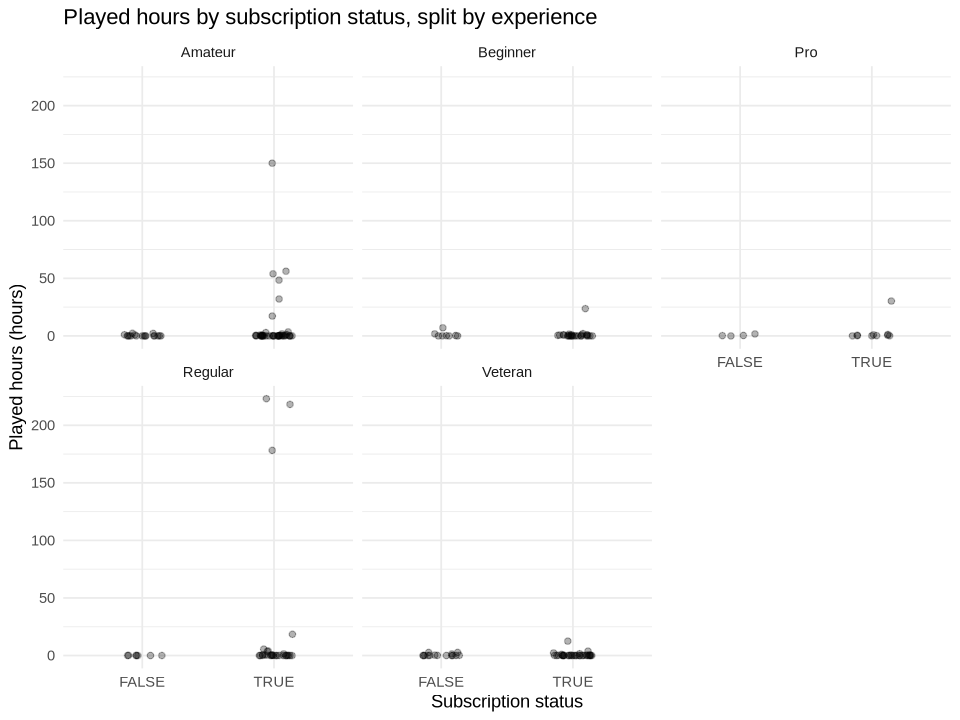

In [57]:
played_hours_by_subscribe_split_exp <- players_subset_clean |>
    ggplot(aes(x = subscribe, y = played_hours)) +
    geom_point(position = position_jitter(width = 0.15), alpha = 0.3) +
    facet_wrap(~ experience) +
    labs(
        title = "Played hours by subscription status, split by experience",
        x = "Subscription status",
        y = "Played hours (hours)"
        ) +
    theme_minimal()

played_hours_by_subscribe_split_exp

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


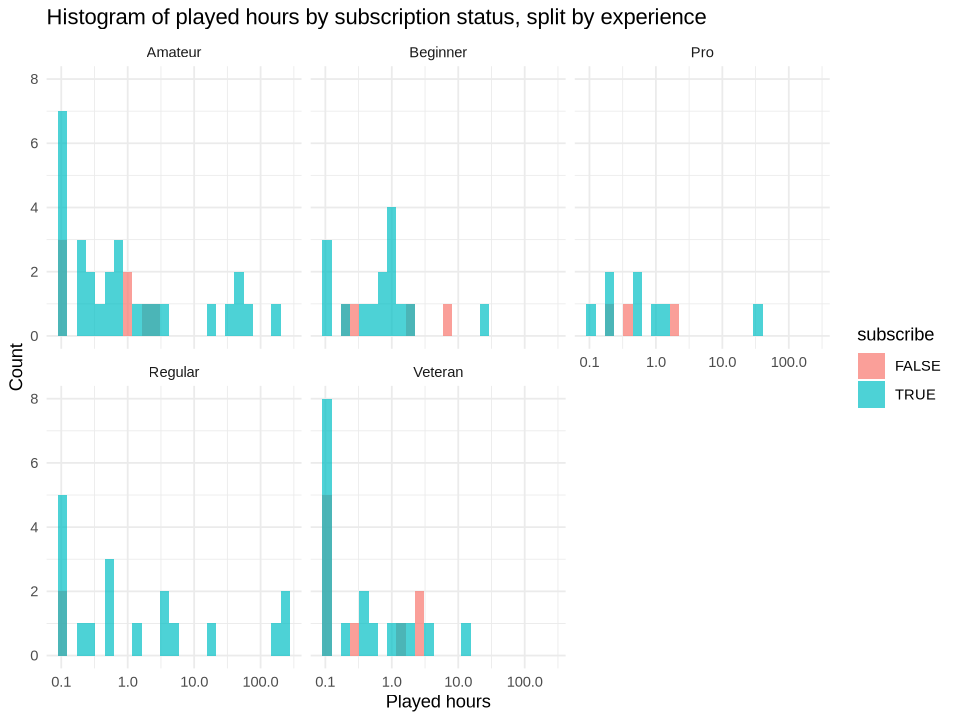

In [58]:
histogram_play_hours_by_sub_split_exp <- players_subset_clean |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 25, alpha = 0.7, position = "identity") +
  facet_wrap(~ experience) +
  labs(
    title = "Histogram of played hours by subscription status, split by experience",
    x = "Played hours",
    y = "Count"
  ) +
  theme_minimal()

#notice the scale was way off, fixed by log-ing the scale
histogram_play_hours_by_sub_split_exp <- histogram_play_hours_by_sub_split_exp + scale_x_log10()
histogram_play_hours_by_sub_split_exp


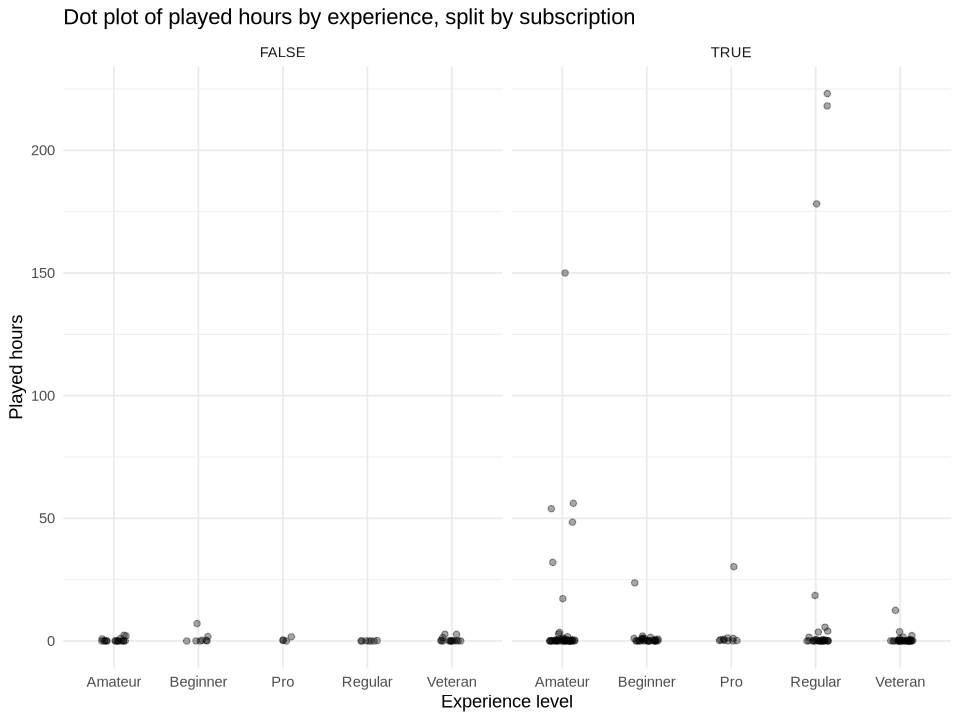

In [59]:
dot_by_experience_plot <- players_subset_clean |>
  ggplot(aes(x = experience, y = played_hours)) +
  geom_point(position = position_jitter(width = 0.15), alpha = 0.35) +
  facet_wrap(~ subscribe) +
  labs(
    title = "Dot plot of played hours by experience, split by subscription",
    x = "Experience level",
    y = "Played hours"
  ) +
  theme_minimal()

dot_by_experience_plot

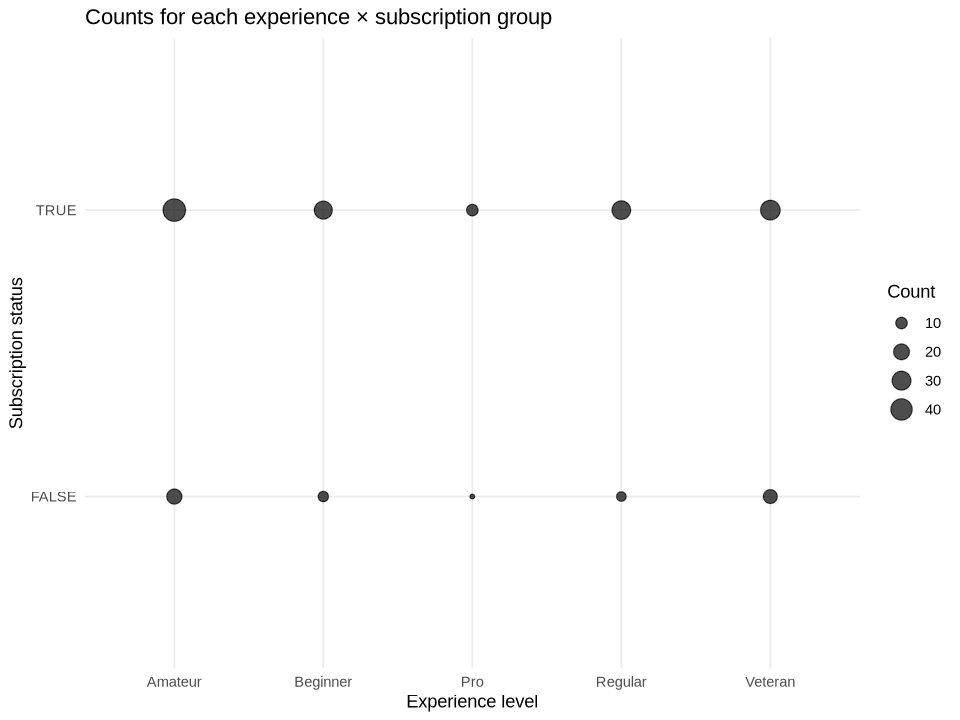

In [51]:
count_grid_plot <- players_subset_clean |>
    count(experience, subscribe) |>
    ggplot(aes(x = experience, y = subscribe)) +
    geom_point(aes(size = n), alpha = 0.7) +
    labs(
        title = "Counts for each experience × subscription group",
        x = "Experience level",
        y = "Subscription status",
        size = "Count"
        ) +
    theme_minimal()

count_grid_plot

# Modelling and K-NN Classification Algorithm

In [61]:
set.seed(123) #chose a seed, I think the number doesn't matter as much as replicability. 
data_split <- initial_split(players_subset_clean, prop = 0.75, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)

In [63]:
player_recipe <- recipe(subscribe ~ experience + played_hours, data = train_data) |>
  step_scale(played_hours) |>
  step_center(played_hours)

player_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: played_hours

• Centering for: played_hours



In [65]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec)

knn_spec
player_workflow

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [69]:
set.seed(123)
player_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

gridvals <- tibble(neighbors = seq(1, 100, by = 5))

player_results <- player_workflow |>
  tune_grid(resamples = player_vfold, grid = gridvals)

best_k <- player_results |>
  select_best(metric = "accuracy")

# best_k

In [70]:
# Finalize workflow with best K
final_workflow <- player_workflow |>
  finalize_workflow(best_k)

# Re-fit the model
player_fit <- final_workflow |>
  fit(data = train_data)

In [76]:
player_preds <- predict(player_fit, test_data) |>
  bind_cols(test_data)

accuracy_error <- player_preds |>
    mutate(correct = (.pred_class == subscribe)) |>
    summarize(
        accuracy = mean(correct),
        error_rate = 1 - mean(correct)
            )

accuracy_error

accuracy,error_rate
<dbl>,<dbl>
0.7142857,0.2857143


          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

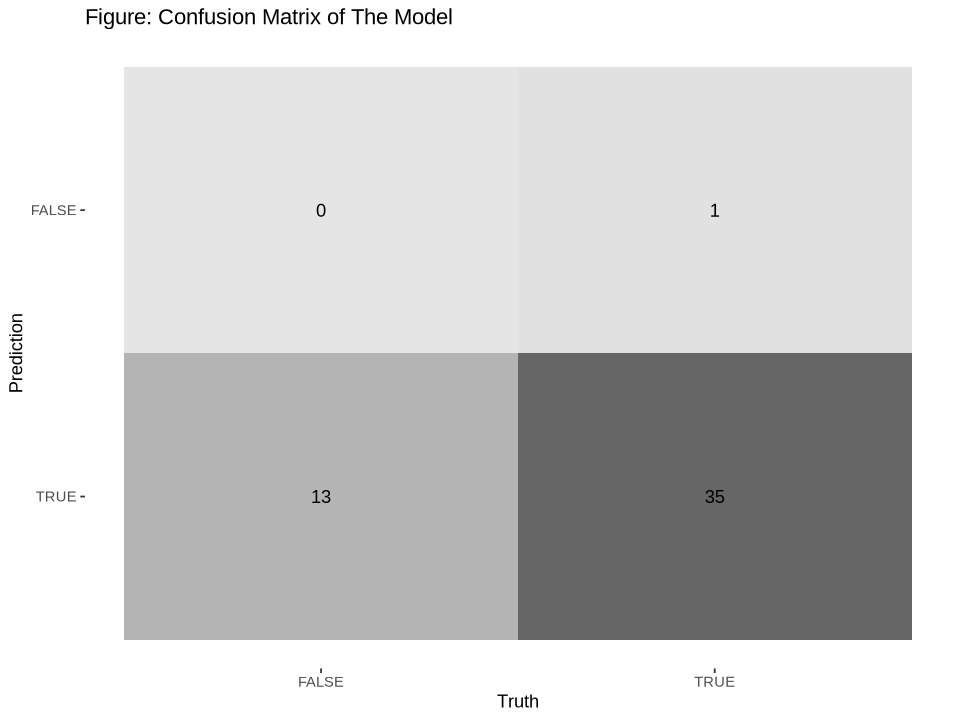

In [74]:
conf_mat <- player_preds |>
  conf_mat(truth = subscribe, estimate = .pred_class)

conf_mat

autoplot(conf_mat, type = "heatmap") +
  labs(title = "Figure: Confusion Matrix of The Model")